In [1]:
import torch
from custom_transformer import CustomTransformer

In [2]:
torch.manual_seed(1234)

In [3]:
# Testing on random input text before actual python scripts to make sure everything works.
with (open("../data/input.txt", "r") as file):
    text = file.read()

vocab = sorted(set(text))
print(len(vocab))

65


In [4]:
ctoi = {ch : i for i, ch in enumerate(vocab)}
itos = {i : ch for i, ch in enumerate(vocab)}

encode = lambda s : [ctoi[c] for c in s]
decode = lambda s : ''.join([itos[i] for i in s])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
data = encode(text)
train_size = int(len(data) * .9)
train = data[:train_size]
test = data[train_size:]

def get_batches(dataset, batches, context_len):
    pos = torch.randint(len(dataset) - context_len, (batches,))
    x = torch.stack([torch.tensor(dataset[x : x + context_len], device=device) for x in pos])
    y = torch.stack([torch.tensor(dataset[x + 1 : x + context_len + 1], device=device) for x in pos])

    return x,y

cuda


In [18]:
CONTEXT_LEN = 8
BLOCK_COUNT = 1
EMBED_DIM = 32
HEAD_SIZE = 8
LEARNING_RATE = 1e-2
BATCH_COUNT = 32

transformer = CustomTransformer(len(vocab), CONTEXT_LEN, EMBED_DIM, HEAD_SIZE, BLOCK_COUNT)
optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

In [25]:
loss_history = []
history = []
loss_avg_block_size = 100
for i in range(5000):
    train_in, train_target = get_batches(train, BATCH_COUNT, CONTEXT_LEN)

    logits, loss = transformer(train_in, train_target)
#    print(logits.shape)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())
    if (i % loss_avg_block_size == 0):
        print (f"Iteration {i} Loss: {history[-1]}")
    if (len(history) >= loss_avg_block_size):
        loss_history.append(torch.tensor(history).mean().item())
        history = []

if (len(history) > 0):
    loss_history.append(torch.tensor(history).mean().item())
print(loss_history[-1])

Iteration 0 Loss: 2.2682344913482666
Iteration 100 Loss: 1.9631965160369873
Iteration 200 Loss: 2.087446451187134
Iteration 300 Loss: 2.083040237426758
Iteration 400 Loss: 2.0832691192626953
Iteration 500 Loss: 2.135869026184082
Iteration 600 Loss: 2.2368526458740234
Iteration 700 Loss: 2.0557587146759033
Iteration 800 Loss: 2.0462818145751953
Iteration 900 Loss: 2.1014959812164307
Iteration 1000 Loss: 1.9533509016036987
Iteration 1100 Loss: 2.1004815101623535
Iteration 1200 Loss: 2.0288524627685547
Iteration 1300 Loss: 2.16239595413208
Iteration 1400 Loss: 1.9702099561691284
Iteration 1500 Loss: 2.1060562133789062
Iteration 1600 Loss: 2.103456735610962
Iteration 1700 Loss: 2.0722885131835938
Iteration 1800 Loss: 1.9759548902511597
Iteration 1900 Loss: 2.108895778656006
Iteration 2000 Loss: 2.081735372543335
Iteration 2100 Loss: 2.2137057781219482
Iteration 2200 Loss: 2.0756447315216064
Iteration 2300 Loss: 2.2073628902435303
Iteration 2400 Loss: 2.0363991260528564
Iteration 2500 Loss:

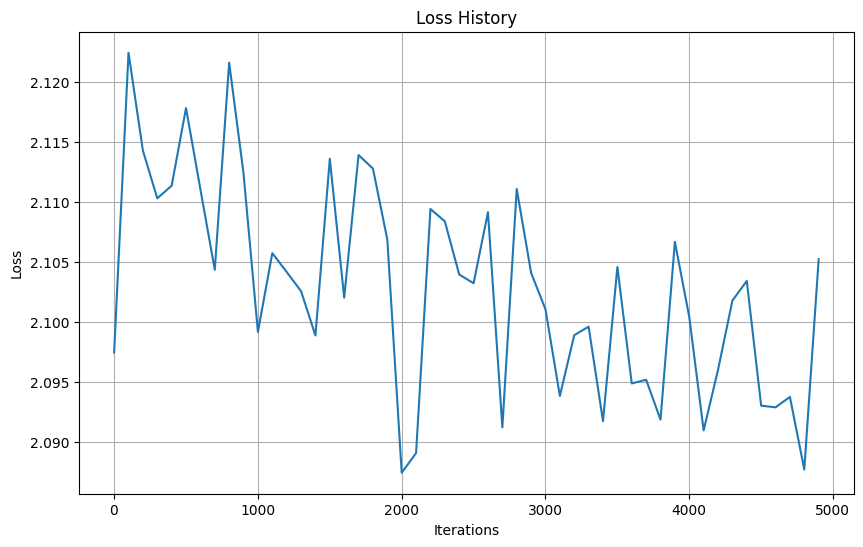

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history * loss_avg_block_size) + 1, loss_avg_block_size), loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.grid(True)
plt.show()


In [16]:
def complete(ctx, new_len):
    res = [x for x in encode(ctx)]
    for _ in range(new_len):
        ctx = torch.tensor([res[-CONTEXT_LEN:]])
        prob, loss = transformer(ctx, None) # Returns a tensor of size (1, W, EM)
        prob = prob.squeeze(0)
        prob = torch.softmax(prob, dim=-1) # (1, W, EM)
        pred = torch.multinomial(prob, 1) # (1, W, 1)
        res.append(pred[-1, 0].item())
    return decode(res[-new_len:])

In [30]:
start = 100
sampled_txt = text[start:start+CONTEXT_LEN]
print("_________________________SAMPLED_________________________:")
print(sampled_txt)
print("_________________________PREDICTED_______________________:")
print(complete(sampled_txt, 16))

_________________________SAMPLED_________________________:
 are all
_________________________PREDICTED_______________________:
, the find, see 
